In [4]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn

# package to clean text
import re

In [5]:
df = pd.read_csv('climate_tweets.csv')

In [6]:
df.head()

,tweet
0,Global warming report urges governments to act...
1,Fighting poverty and global warming in Africa ...
2,Carbon offsets: How a Vatican forest failed to...
3,Carbon offsets: How a Vatican forest failed to...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...


In [7]:
# make a new column to highlight retweets
df['is_retweet'] = df['tweet'].apply(lambda x: x[:2]=='RT')
df['is_retweet'].sum()  # number of retweets

np.int64(773)

In [8]:
 # number of unique retweets
df.loc[df['is_retweet']].tweet.unique().size


677

In [9]:
# 10 most repeated tweets
df.groupby(['tweet']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,tweet,counts
3131,No matter if you believe in global warming or ...,20
4555,Take Action @change: Help Protect Wildlife Hab...,14
4027,RT @newtgingrich: Historic snow storm in washi...,9
1765,Fight Climate Change From All Fronts: [link],8
1941,Global Warming Dent's El Ni'o's Protective Shi...,7
1626,Earth's polar ice sheets vulnerable to even mo...,7
1351,Coalition of the Tired of Waiting: Fighting Cl...,6
4359,Senators prepare compromise climate change bil...,6
1040,Carbon offsets: How a Vatican forest failed to...,6
4271,SCIENCE: Scientists explore the evolution of c...,6


TypeError: LogScale.__init__() got an unexpected keyword argument 'nonposy'

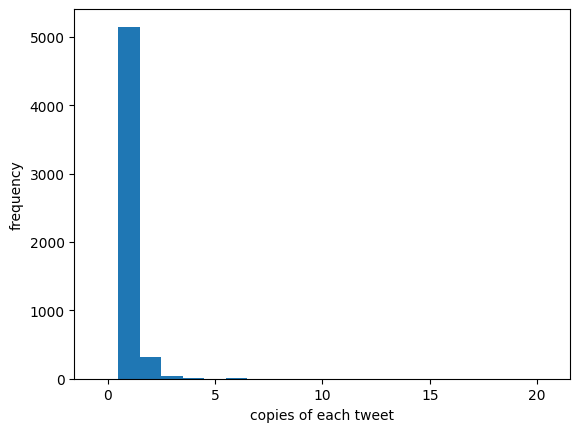

In [10]:
# number of times each tweet appears
counts = df.groupby(['tweet']).size()\
           .reset_index(name='counts')\
           .counts

# define bins for histogram
my_bins = np.arange(0,counts.max()+2, 1)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('copies of each tweet')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [11]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ecarrasco\AppData\Local\Temp\ipykernel_8540\898943074.py:3: SyntaxWarning: invalid escape sequence '\s'
  return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
C:\Users\ecarrasco\AppData\Local\Temp\ipykernel_8540\898943074.py:7: SyntaxWarning: invalid escape sequence '\s'
  return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)


In [12]:
# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df.tweet.apply(find_retweeted)
df['mentioned'] = df.tweet.apply(find_mentioned)
df['hashtags'] = df.tweet.apply(find_hashtags)

In [13]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [14]:
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [15]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

TypeError: LogScale.__init__() got an unexpected keyword argument 'nonposy'

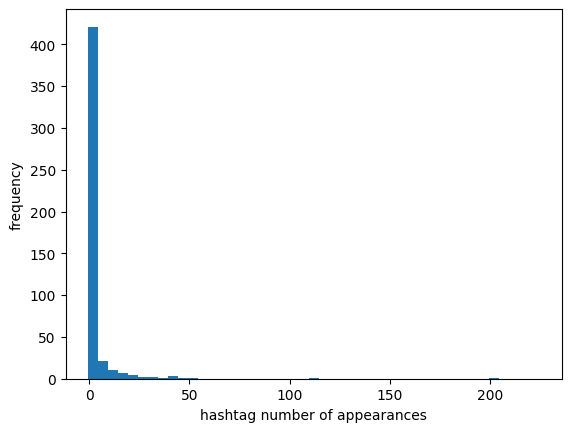

In [16]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

# From Text to Vector

In [17]:
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

In [18]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]


In [19]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [21]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [22]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ecarrasco\AppData\Local\Temp\ipykernel_8540\2919398205.py:10: SyntaxWarning: invalid escape sequence '\s'
  tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet


In [23]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ecarrasco\AppData\Local\Temp\ipykernel_8540\3887010983.py:11: SyntaxWarning: invalid escape sequence '\s'
  tweet = re.sub('\s+', ' ', tweet) #remove double spacing


In [24]:
df['clean_tweet'] = df.tweet.apply(clean_tweet)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names_out()

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
C:\Users\ecarrasco\AppData\Local\Temp\ipykernel_8540\316886415.py:4: SyntaxWarning: invalid escape sequence '\w'
  vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')


In [27]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [28]:
model.fit(tf)

LatentDirichletAllocation(random_state=0)

In [29]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [30]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,1220.2,global,666.5,global,1147.2,global,473.1,climat,422.0,global,783.0,chang,666.1,warm,167.9,climat,568.3,climat,529.9
1,chang,1184.5,warm,658.1,warm,1102.1,warm,450.7,chang,401.8,warm,764.7,climat,661.6,#climate,139.2,chang,550.5,chang,520.6
2,via,257.9,snow,160.5,scientist,150.2,believ,101.3,legisl,123.2,gore,137.1,energi,178.8,volcano,128.9,new,321.1,peopl,153.4
3,scienc,112.9,#tcot,121.6,say,87.1,california,87.1,us,105.1,snow,123.7,u,109.8,global,128.6,bill,116.9,world,151.3
4,news,79.5,like,99.0,scienc,71.7,blame,82.1,via,60.5,al,122.1,via,96.5,chang,122.0,senat,106.1,confer,110.1
5,day,77.8,blizzard,90.9,debat,66.6,law,78.6,say,55.9,great,94.1,nation,89.0,help,114.1,agenc,95.1,bill,106.4
6,earth,68.2,dc,86.5,man,61.1,report,77.8,video,55.9,cold,77.1,make,74.5,take,96.8,immigr,77.7,talk,94.8
7,clinic,68.1,think,83.3,made,54.0,save,61.8,place,54.1,call,76.5,impact,67.5,climat,76.7,obama,75.6,graham,92.1
8,trial,68.1,due,80.1,show,51.9,money,56.1,good,52.6,#tcot,75.3,report,63.4,iceland,67.1,feder,67.1,un,77.6
9,carbon,64.5,make,70.4,water,50.6,live,49.3,human,48.2,one,72.1,issu,58.8,could,64.5,via,58.6,put,68.8
